In [1]:
import lightning.pytorch as pl
import numpy as np
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

from config import Config, load_config
from datasets import get_data
from models import get_model

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [97]:
# initialize data attributes and loaders
%env BATCH_SIZE=256
%env DATASET_NAME=QPM_species
%env EMB_DIMS=128
%env MODEL_NAME=flow_mse
%env OOD=4

config = load_config()
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

env: BATCH_SIZE=256
env: DATASET_NAME=QPM_species
env: EMB_DIMS=128
env: MODEL_NAME=flow_mse
env: OOD=4


In [98]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species
Loaded 344518 images
Dataset type val label type: species
Loaded 44696 images
Dataset type test label type: species
Loaded 44924 images
Dataset type train label type: species
Loaded 30925 images
Dataset type val label type: species
Loaded 3866 images
Dataset type test label type: species
Loaded 3866 images


In [99]:
model = config.get_model()

In [100]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

fwur6c78


In [101]:
from pathlib import Path
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [102]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [103]:
from models.common import edl_probs
from tqdm.auto import tqdm

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, *_ = batch
    x = x.float().cuda()
    v, z, x_m, logits = model(x)
    v_norms = v.detach().flatten(start_dim=1).norm(dim=-1).cpu().numpy()
    ind_v_norms.extend(v_norms)
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, *_ = batch
    x = x.float().cuda()
    v, z, x_m, logits = model(x)
    v_norms = v.detach().flatten(start_dim=1).norm(dim=-1).cpu().numpy()
    ood_v_norms.extend(v_norms)
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, logits = model(x)
    v_norms = v.detach().flatten(start_dim=1).norm(dim=-1).cpu().numpy()
    rnd_v_norms.extend(v_norms)
print("test RnD - OK")
    
ind_v_norms = np.array(ind_v_norms)
ood_v_norms = np.array(ood_v_norms)
rnd_v_norms = np.array(rnd_v_norms)

print(ind_v_norms.shape)
print(ood_v_norms.shape)
print(rng_v_norms.shape)

100%|██████████| 176/176 [00:06<00:00, 27.38it/s]


test InD - OK


100%|██████████| 152/152 [00:05<00:00, 27.15it/s]


test OoD - OK


100%|██████████| 100/100 [00:03<00:00, 30.93it/s]

test RnD - OK
(44924,)
(38657,)
(32000,)


In [104]:
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

0.0047694477 0.001904325
0.0041454616 0.011519242
10.991685 0.3497253


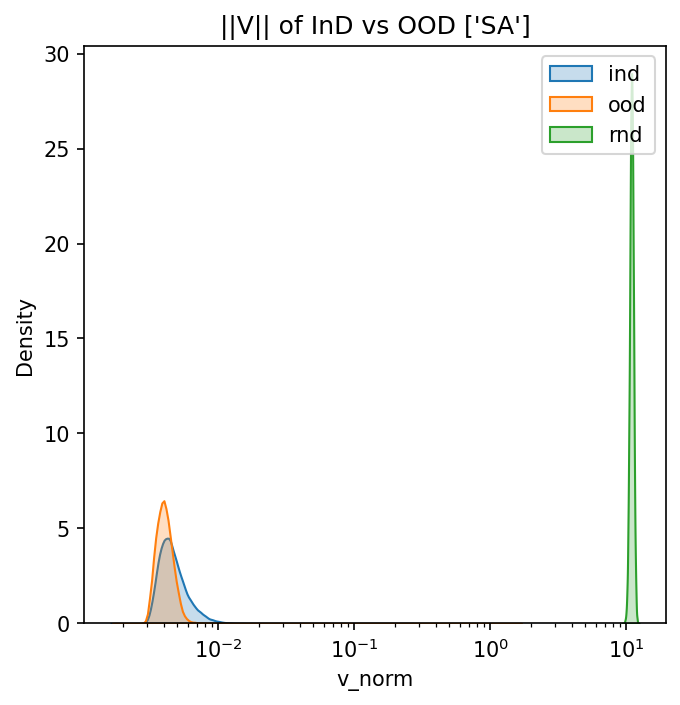

In [105]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(v_norm=ind_v_norms))
data_ood = pd.DataFrame(dict(v_norm=ood_v_norms))
data_rnd = pd.DataFrame(dict(v_norm=rnd_v_norms))

sns.kdeplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind')
sns.kdeplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood')
sns.kdeplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd')

plt.title(f"||V|| of InD vs OOD {config.ood_labels}")
plt.legend()
plt.savefig(f"assets/figures/qpm_species_flow_mse_M128_ood_{config.ood[0]}.png")